In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import io
from PIL import Image

In [2]:
episodes_dataset = tf.data.TFRecordDataset(
    "gs://rl_unplugged/atari_episodes_ordered/Pong/run_1-00000-of-00050",
    compression_type="GZIP"
)

In [3]:
raw_example = next(iter(episodes_dataset))

example = tf.train.Example()
example.ParseFromString(raw_example.numpy())

print("Features in the TFRecord example:")
for key in example.features.feature.keys():
    feature = example.features.feature[key]
    # Print the type of data stored in this feature
    if feature.bytes_list.value:
        dtype = "bytes"
    elif feature.int64_list.value:
        dtype = "int64"
    elif feature.float_list.value:
        dtype = "float"
    else:
        dtype = "unknown"
    print(f"{key}: {dtype}")

Features in the TFRecord example:
clipped_rewards: float
unclipped_rewards: float
episode_return: float
clipped_episode_return: float
discounts: float
observations: bytes
actions: int64
checkpoint_idx: int64
episode_idx: int64


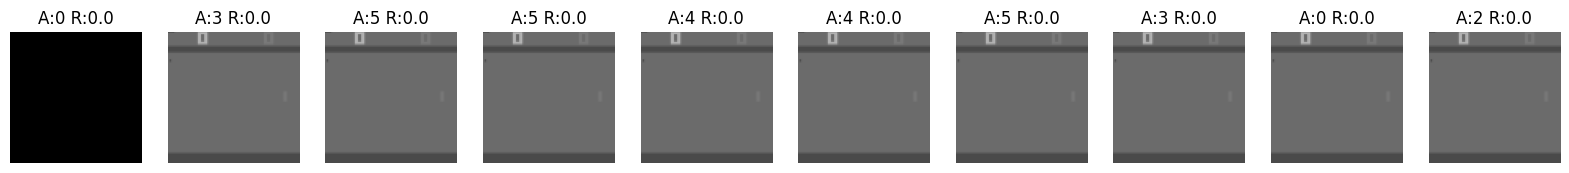

In [4]:

feature_description = {
    "observations": tf.io.VarLenFeature(tf.string),
    "actions": tf.io.VarLenFeature(tf.int64),
    "clipped_rewards": tf.io.VarLenFeature(tf.float32),
}

def _parse_function(example_proto):
    parsed = tf.io.parse_single_example(example_proto, feature_description)

    obs = tf.sparse.to_dense(parsed["observations"])
    actions = tf.sparse.to_dense(parsed["actions"])
    rewards = tf.sparse.to_dense(parsed["clipped_rewards"])

    img = tf.io.decode_image(obs[0], channels=3)
    return img, actions[0], rewards[0]

dataset_parsed = episodes_dataset.map(_parse_function)

# Plot first 10 frames with actions and rewards
plt.figure(figsize=(20, 4))
for i, (frame, action, reward) in enumerate(dataset_parsed.take(10)):
    plt.subplot(2, 10, i+1)
    plt.imshow(frame.numpy())       # now .numpy() is fine outside map
    plt.axis('off')
    plt.title(f"A:{action.numpy()} R:{reward.numpy():.1f}")
plt.show()

In [5]:
!git clone https://github.com/Coluding/world-models.git

Cloning into 'world-models'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 65 (delta 13), reused 59 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (65/65), 153.67 KiB | 25.61 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [6]:
import sys
sys.path.append('/content/world-models')
from models.rssm import RSSM

import torch
from torch.utils.data import Dataset, DataLoader

In [7]:
feature_description = {
  "observations": tf.io.VarLenFeature(tf.string),
  "actions": tf.io.VarLenFeature(tf.int64),
  "clipped_rewards": tf.io.VarLenFeature(tf.float32),
}

def parse_sequence(example_proto):
  parsed = tf.io.parse_single_example(example_proto, feature_description)
  obs = tf.sparse.to_dense(parsed["observations"])
  actions = tf.sparse.to_dense(parsed["actions"])
  rewards = tf.sparse.to_dense(parsed["clipped_rewards"])
  imgs = tf.map_fn(lambda x: tf.io.decode_image(x, channels=3), obs, dtype=tf.uint8)
  #imgs.set_shape([None, 84, 84, 3])
  #imgs = tf.image.resize(imgs, [64, 64])
  imgs = tf.cast(imgs, tf.float32) / 255.0
  actions = tf.cast(actions, tf.int64)
  rewards = tf.cast(rewards, tf.float32)
  return imgs, actions, rewards

sequence_length = 50
batch_size = 16

episodes_dataset = tf.data.TFRecordDataset(
    "gs://rl_unplugged/atari_episodes_ordered/Pong/run_1-00000-of-00050",
    compression_type="GZIP"
)
dataset = episodes_dataset.map(parse_sequence)
dataset = dataset.filter(lambda imgs, actions, rewards: tf.shape(imgs)[0] >= sequence_length)
dataset = dataset.map(lambda imgs, actions, rewards: (
    imgs[:sequence_length], actions[:sequence_length], rewards[:sequence_length]
))
dataset = dataset.batch(batch_size, drop_remainder=True)

Instructions for updating:
Use fn_output_signature instead


(865, 84, 84, 3)
(865,)
(865,)


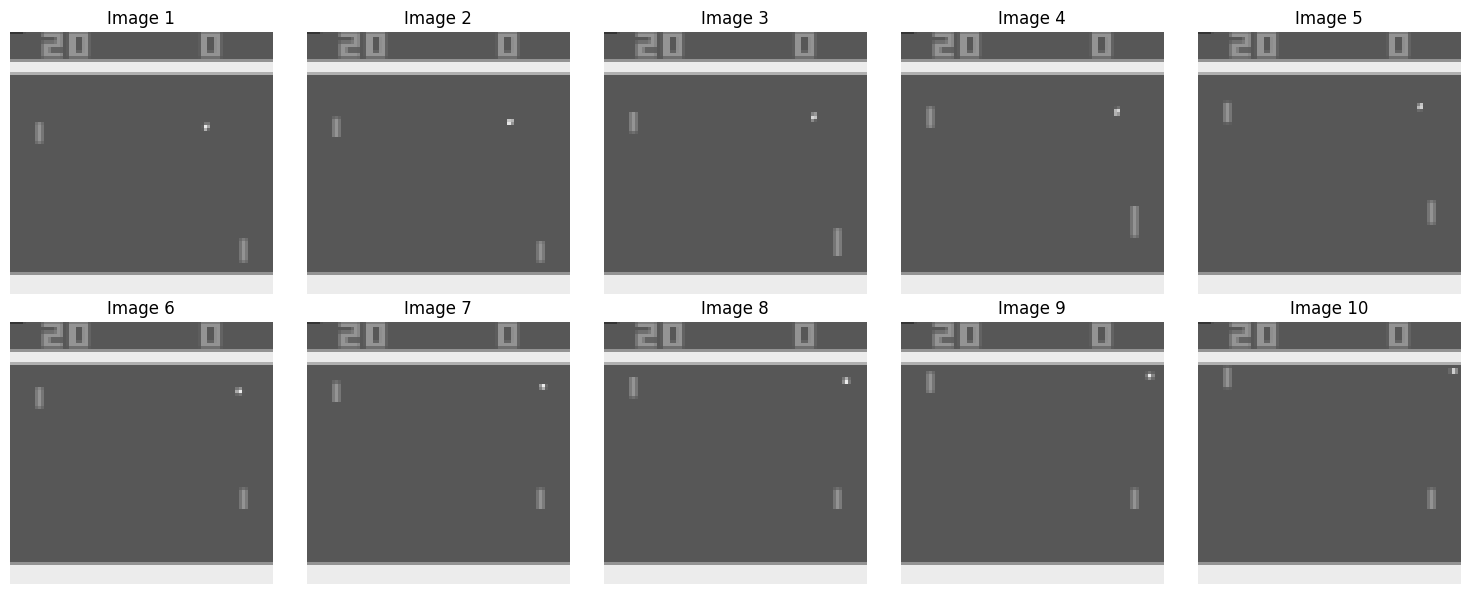

In [8]:

example = next(iter(episodes_dataset.take(1)))
imgs, actions, rewards = parse_sequence(example)

print(imgs.shape)
print(actions.shape)
print(rewards.shape)

last_ten_imgs = imgs[-10:]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
  ax.imshow(last_ten_imgs[i], vmin=0, vmax=1)
  ax.set_title(f"Image {i+1}")
  ax.axis("off")
plt.tight_layout()
plt.show()


In [9]:
for imgs, actions, rewards in dataset.take(1):
  print("imgs:", imgs.shape)
  print("actions:", actions.shape)
  print("rewards:", rewards.shape)

imgs: (16, 50, 84, 84, 3)
actions: (16, 50)
rewards: (16, 50)


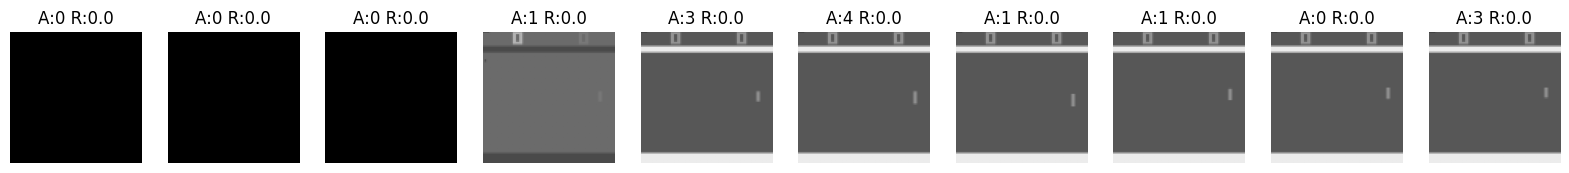

In [10]:
for imgs, actions, rewards in dataset.take(1):
  seq_imgs = imgs[0]
  seq_actions = actions[0]
  seq_rewards = rewards[0]

  plt.figure(figsize=(20, 4))
  for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(seq_imgs[i].numpy())
    plt.axis("off")
    plt.title(f"A:{seq_actions[i].numpy()} R:{seq_rewards[i].numpy():.1f}")
  plt.show()

In [11]:
def parse_sequence_for_inspection(example_proto):
    parsed = tf.io.parse_single_example(example_proto, feature_description)
    obs = tf.sparse.to_dense(parsed["observations"])
    imgs = tf.map_fn(lambda x: tf.io.decode_image(x, channels=3), obs, dtype=tf.uint8)
    print("Original image shape (before resizing):", imgs.shape)
    return imgs

example = next(iter(episodes_dataset.take(1)))
imgs = parse_sequence_for_inspection(example)

Original image shape (before resizing): (865, 84, 84, 3)


In [12]:
class AtariSequenceDataset(Dataset):
  def __init__(self, tf_dataset, num_batches):
    self.data = []
    for i, (imgs, actions, rewards) in enumerate(tf_dataset):
      if i >= num_batches:
        break
      self.data.append((
        imgs.numpy(), actions.numpy(), rewards.numpy()
      ))
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    imgs, actions, rewards = self.data[idx]
    imgs = torch.tensor(imgs, dtype=torch.float32)  # [seq, 64, 64, 3]
    actions = torch.tensor(actions, dtype=torch.long)  # [seq]
    rewards = torch.tensor(rewards, dtype=torch.float32)  # [seq]
    return imgs, actions, rewards

In [13]:
num_batches = 100
atari_dataset = AtariSequenceDataset(dataset, num_batches)
dataloader = DataLoader(atari_dataset, batch_size=1, shuffle=True)

In [14]:
from models.models import EncoderCNN, DecoderCNN, RewardModel
from models.rssm import RSSM
from models.dynamics import DynamicsModel

device = "cuda" if torch.cuda.is_available() else "cpu"
action_dim = 6
embedding_dim = 1024
hidden_size = 1024
state_size = 30
embedding_size = 16384

encoder = EncoderCNN(in_channels=3, embedding_dim=embedding_size, input_shape=(3, 64, 64)).to(device)
decoder = DecoderCNN(hidden_size, state_size, embedding_size, use_bn=True, output_shape=(3, 64, 64)).to(device)
reward_model = RewardModel(hidden_size, state_size).to(device)
dynamics_model = DynamicsModel(hidden_size, state_size, action_dim, embedding_size).to(device)

rssm = RSSM(encoder, decoder, reward_model, dynamics_model, hidden_size, state_size, action_dim, embedding_size, device=device)
optimizer = torch.optim.Adam(rssm.parameters(), lr=1e-3)


# Training JEPA Decoder

In [16]:
# train_decoder_vjepa2.py
# ---------------------------------------------------------------
# Requires: pip install torch torchvision timm einops tensorflow
# Optional (HF backend): pip install transformers decord (or eva-decord/decord2 on macOS)
# ---------------------------------------------------------------
import os, math, numpy as np, tensorflow as tf
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# ---- Config ----
VJEPA_BACKEND = os.environ.get("VJEPA_BACKEND", "hub")   # "hub" or "hf"
USE_AC = bool(int(os.environ.get("VJEPA_USE_AC", "0")))  # 1=use AC variant via hub
HF_REPO = os.environ.get("VJEPA_HF_REPO", "facebook/vjepa2-vitl-fpc64-256")

TFRECORD_PATH = "gs://rl_unplugged/atari_episodes_ordered/Pong/run_1-00000-of-00050"
SEQ_LEN = 50
K_FRAMES = 16
BATCH_TF = 8
BATCH_TORCH = 16
USE_GRAYSCALE = True
EPOCHS = 5
LR = 1e-3

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# ---------------- TFRecords -> tf.data ----------------
feature_description = {
    "observations": tf.io.VarLenFeature(tf.string),
    "actions": tf.io.VarLenFeature(tf.int64),
    "clipped_rewards": tf.io.VarLenFeature(tf.float32),
}

def _decode_frame(x):
    img = tf.io.decode_image(x, channels=3, expand_animations=False)  # uint8
    img = tf.image.resize(img, [64, 64], antialias=True)
    return tf.cast(img, tf.uint8)

def parse_sequence(example_proto):
    parsed = tf.io.parse_single_example(example_proto, feature_description)
    obs = tf.sparse.to_dense(parsed["observations"])
    acts = tf.sparse.to_dense(parsed["actions"])
    rews = tf.sparse.to_dense(parsed["clipped_rewards"])
    imgs = tf.map_fn(_decode_frame, obs, fn_output_signature=tf.uint8)  # (T,64,64,3)
    return imgs, tf.cast(acts, tf.int64), tf.cast(rews, tf.float32)

episodes_dataset = tf.data.TFRecordDataset(TFRECORD_PATH, compression_type="GZIP")
dataset = (episodes_dataset
           .map(parse_sequence, num_parallel_calls=tf.data.AUTOTUNE)
           .filter(lambda im, a, r: tf.shape(im)[0] >= SEQ_LEN)
           .map(lambda im, a, r: (im[:SEQ_LEN], a[:SEQ_LEN], r[:SEQ_LEN]))
           .batch(BATCH_TF, drop_remainder=True)
           .prefetch(tf.data.AUTOTUNE))

# ------------- Bridge to PyTorch per-sequence items -------------
class AtariSequenceDataset(Dataset):
    def __init__(self, tf_dataset, num_tf_batches: int):
        self.frames, self.actions, self.rewards = [], [], []
        cnt = 0
        for imgs_tf, acts_tf, rews_tf in tf_dataset:
            B = imgs_tf.shape[0]
            imgs = imgs_tf.numpy().astype(np.uint8)  # (B,T,64,64,3)
            acts = acts_tf.numpy()
            rews = rews_tf.numpy()
            for b in range(B):
                self.frames.append(imgs[b])           # (T,64,64,3)
                self.actions.append(acts[b])
                self.rewards.append(rews[b])
            cnt += 1
            if cnt >= num_tf_batches:
                break
    def __len__(self): return len(self.frames)
    def __getitem__(self, idx):
        # Return float [0,1]
        imgs = torch.from_numpy(self.frames[idx].astype(np.float32) / 255.0)  # (T,64,64,3)
        acts = torch.from_numpy(self.actions[idx]).long()
        rews = torch.from_numpy(self.rewards[idx]).float()
        return imgs, acts, rews

NUM_TF_BATCHES_TO_LOAD = int(os.environ.get("NUM_TF_BATCHES", "100"))
pt_dataset = AtariSequenceDataset(dataset, NUM_TF_BATCHES_TO_LOAD)
pt_loader = DataLoader(pt_dataset, batch_size=BATCH_TORCH, shuffle=True, num_workers=0, drop_last=True)
print(f"Loaded {len(pt_dataset)} sequences.")

# -------------------- Load V-JEPA 2 (hub or HF) --------------------
preprocessor = None
vjepa_model = None
vjepa_ac_predictor = None

if VJEPA_BACKEND == "hub":
    # Requires timm + einops installed
    preprocessor = torch.hub.load('facebookresearch/vjepa2', 'vjepa2_preprocessor')
    if USE_AC:
        obj = torch.hub.load('facebookresearch/vjepa2', 'vjepa2_ac_vit_giant')
        # AC returns (encoder, predictor)
        if isinstance(obj, tuple):
            vjepa_model, vjepa_ac_predictor = obj[0], obj[1]
        else:
            vjepa_model = obj
        print("Loaded V-JEPA 2-AC (ViT-g) from hub.")
    else:
        obj = torch.hub.load('facebookresearch/vjepa2', 'vjepa2_vit_large')
        vjepa_model = obj[0] if isinstance(obj, tuple) else obj
        print("Loaded V-JEPA 2 (ViT-L) from hub.")

    vjepa_model.to(device).eval()
    for p in vjepa_model.parameters(): p.requires_grad_(False)

elif VJEPA_BACKEND == "hf":
    from transformers import AutoVideoProcessor, AutoModel
    vjepa_model = AutoModel.from_pretrained(HF_REPO).to(device).eval()
    preprocessor = AutoVideoProcessor.from_pretrained(HF_REPO)
    for p in vjepa_model.parameters(): p.requires_grad_(False)
    print(f"Loaded {HF_REPO} from Hugging Face.")
else:
    raise ValueError("VJEPA_BACKEND must be 'hub' or 'hf'.")

# -------------------- frames -> tokens helper --------------------
@torch.no_grad()
# --- helper: get expected (H', W') from the backbone/preprocessor -------------
def _infer_grid_hw():
    # Try to read it from the model (most timm ViTs have patch_embed.grid_size)
    Ht = Wt = None
    if hasattr(vjepa_model, "patch_embed"):
        pe = vjepa_model.patch_embed
        if hasattr(pe, "grid_size") and pe.grid_size is not None:
            try:
                gs = pe.grid_size
                if isinstance(gs, (tuple, list)) and len(gs) == 2:
                    return int(gs[0]), int(gs[1])
            except Exception:
                pass
        # fall back: patch size + processor target size
        patch = None
        if hasattr(pe, "patch_size"):
            ps = pe.patch_size
            if isinstance(ps, (tuple, list)): patch = int(ps[0])
            elif isinstance(ps, int): patch = ps
        # hub preprocessor typically resizes to 256; HF variants may do 256/384
        target = 256
        if VJEPA_BACKEND == "hf":
            try:
                size = preprocessor.size
                if isinstance(size, dict) and "shortest_edge" in size:
                    target = int(size["shortest_edge"])
                elif isinstance(size, int):
                    target = size
            except Exception:
                pass
        if patch and target % patch == 0:
            Ht = Wt = target // patch
            return Ht, Wt
    # safe default for ViT-16 at 256px
    return 16, 16

# -------------------- frames -> tokens (robust folding) -----------------------
@torch.no_grad()
def frames_to_tokens(frames_bchw: torch.Tensor) -> torch.Tensor:
    """
    frames_bchw: (B, C, 64, 64) in [0,1].
    Returns tokens as (B, D, H', W').
    Handles (B,N,D) and (B,T,N,D) by folding N to (G * H'*W').
    """
    Ht_exp, Wt_exp = _infer_grid_hw()  # e.g., (16,16) for ViT-16 @ 256
    spatial_tokens = Ht_exp * Wt_exp

    if VJEPA_BACKEND == "hub":
        # hub preprocessor returns list[tensor] -> stack to (B,C,256,256)
        proc_list = preprocessor([f.cpu() for f in frames_bchw])
        proc = torch.stack(proc_list, dim=0).to(device) if isinstance(proc_list, (list, tuple)) else proc_list.to(device)
        out = vjepa_model(proc)
        # normalize out->x
        if isinstance(out, (list, tuple)) and len(out) > 0:
            x = out[0]
        elif isinstance(out, dict):
            for k in ("x", "feats", "last_hidden_state", "tokens"):
                if k in out: x = out[k]; break
            else:
                x = next(iter(out.values()))
        else:
            x = out

    else:  # HF
        frames_uint8 = (frames_bchw.clamp(0,1)*255).byte().cpu().permute(0,2,3,1).numpy()
        videos = [f[None, ...] for f in frames_uint8]  # list of (T=1,H,W,C)
        inputs = preprocessor(videos=videos, return_tensors="pt").to(device)
        out = vjepa_model(**inputs)
        x = None
        for attr in ("last_hidden_state", "x", "feats"):
            if hasattr(out, attr): x = getattr(out, attr); break
        if x is None and isinstance(out, (tuple, list)) and len(out) > 0:
            x = out[0]
        if x is None:
            raise RuntimeError(f"Cannot find tokens in HF outputs: {type(out)}")

    # ---- shape handling ----
    if x.dim() == 4 and x.size(1) < 64:
        # already (B, D, H', W')
        tokens = x

    elif x.dim() == 3:
        # (B, N, D) — N may be G * (H'*W')
        B, N, D = x.shape
        if N % spatial_tokens == 0:
            G = N // spatial_tokens
            x = x.view(B, G, spatial_tokens, D)         # (B,G,H'W',D)
            x = x.mean(dim=1)                           # average over views/clips
            tokens = x.view(B, Ht_exp, Wt_exp, D).permute(0, 3, 1, 2).contiguous()
        else:
            # last resort: take first H'W' tokens
            take = min(N, spatial_tokens)
            x = x[:, :take, :]
            pad_needed = spatial_tokens - take
            if pad_needed > 0:
                x = torch.cat([x, x[:, -1:, :].expand(B, pad_needed, D)], dim=1)
            tokens = x.view(B, Ht_exp, Wt_exp, D).permute(0, 3, 1, 2).contiguous()

    elif x.dim() == 4 and x.size(1) > 64:
        # (B, T, N, D) — pick first T slice, then fold N
        B, T, N, D = x.shape
        x = x[:, 0]
        if N % spatial_tokens == 0:
            G = N // spatial_tokens
            x = x.view(B, G, spatial_tokens, D).mean(dim=1)
            tokens = x.view(B, Ht_exp, Wt_exp, D).permute(0, 3, 1, 2).contiguous()
        else:
            take = min(N, spatial_tokens)
            x = x[:, :take, :]
            pad_needed = spatial_tokens - take
            if pad_needed > 0:
                x = torch.cat([x, x[:, -1:, :].expand(B, pad_needed, D)], dim=1)
            tokens = x.view(B, Ht_exp, Wt_exp, D).permute(0, 3, 1, 2).contiguous()
    else:
        raise RuntimeError(f"Unexpected V-JEPA output shape: {tuple(x.shape)}")

    return tokens


# -------------------- Decoder head --------------------
def make_upsampler(in_ch: int, out_ch: int, h_tokens: int, w_tokens: int) -> nn.Sequential:
    assert h_tokens == w_tokens, "Expect square token grid."
    layers = [nn.Conv2d(in_ch, 256, 1), nn.ReLU(inplace=True)]
    curr = h_tokens
    ch = 256
    while curr < 64:
        next_ch = max(64, ch // 2)
        layers += [nn.ConvTranspose2d(ch, next_ch, 4, 2, 1), nn.ReLU(inplace=True)]
        ch = next_ch
        curr *= 2
    layers += [nn.Conv2d(ch, out_ch, 3, padding=1), nn.Sigmoid()]
    return nn.Sequential(*layers)

class VJEPADecoder(nn.Module):
    def __init__(self, d: int, h_tokens: int, w_tokens: int, out_ch: int = 1):
        super().__init__()
        self.net = make_upsampler(d, out_ch, h_tokens, w_tokens)
    def forward(self, tokens: torch.Tensor) -> torch.Tensor:
        out = self.net(tokens)  # (B,out_ch,~64,~64)
        if out.shape[-2:] != (64, 64):
            out = F.interpolate(out, size=(64, 64), mode="bilinear", align_corners=False)
        return out

@torch.no_grad()
def probe_token_shape():
    dummy = torch.rand(4, 3, 64, 64, device=device)
    toks = frames_to_tokens(dummy)
    print(f"[probe] token shape: {tuple(toks.shape)}")
    return toks.shape

_, D_tok, Ht, Wt = probe_token_shape()
decoder = VJEPADecoder(D_tok, Ht, Wt, out_ch=1 if USE_GRAYSCALE else 3).to(device)
opt = torch.optim.Adam(decoder.parameters(), lr=LR)

def recon_loss(pred, tgt):
    return 0.5 * F.l1_loss(pred, tgt) + 0.5 * F.mse_loss(pred, tgt)

# -------------------- Training loop --------------------
decoder.train()
for epoch in range(1, EPOCHS + 1):
    running = 0.0
    for imgs, acts, rews in pt_loader:
        # imgs: (B, T, 64, 64, 3) in [0,1]
        imgs = imgs[:, :K_FRAMES].permute(0, 1, 4, 2, 3).contiguous().to(device)  # (B,K,3,64,64)
        frames = imgs.view(-1, 3, 64, 64)  # (B*K,3,64,64)

        if USE_GRAYSCALE:
            # JEPA expects RGB; targets are 1ch
            frames_gray = torch.mean(frames, dim=1, keepdim=True)  # naive gray
            frames_rgb = frames_gray.repeat(1, 3, 1, 1)
            targets = frames_gray
        else:
            frames_rgb = frames
            targets = frames

        with torch.no_grad():
            tokens = frames_to_tokens(frames_rgb)  # (B*K, D, H', W')

        preds = decoder(tokens)
        loss = recon_loss(preds, targets)

        opt.zero_grad(); loss.backward(); opt.step()
        running += loss.item()

    print(f"Epoch {epoch}/{EPOCHS} | recon: {running/len(pt_loader):.4f}")

print("Done.")


Using device: cuda
Loaded 704 sequences.


Using cache found in /root/.cache/torch/hub/facebookresearch_vjepa2_main
Using cache found in /root/.cache/torch/hub/facebookresearch_vjepa2_main


Loaded V-JEPA 2 (ViT-L) from hub.
[probe] token shape: (1, 1024, 16, 16)


/tmp/ipython-input-2414135176.py:275: UserWarning: Using a target size (torch.Size([256, 1, 64, 64])) that is different to the input size (torch.Size([1, 1, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return 0.5 * F.l1_loss(pred, tgt) + 0.5 * F.mse_loss(pred, tgt)


Epoch 1/5 | recon: 0.0625
Epoch 2/5 | recon: 0.0139
Epoch 3/5 | recon: 0.0104
Epoch 4/5 | recon: 0.0099
Epoch 5/5 | recon: 0.0091
Done.


# Reconstruction

PSNR: 35.81 dB  |  SSIM: 0.900


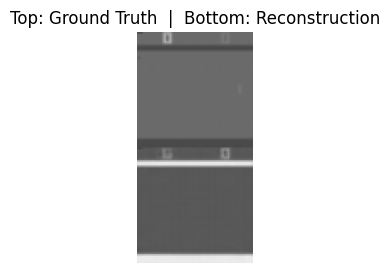

Saved grid to vjepa2_decoder_eval/gt_rec_grid.png


In [17]:
# === EVAL / VISUALIZATION ===
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torch

decoder.eval()

@torch.no_grad()
def psnr(pred, target, eps=1e-8):
    # pred/target in [0,1], shape (N,1,64,64)
    mse = torch.mean((pred - target) ** 2, dim=(1,2,3)) + eps
    return 10.0 * torch.log10(1.0 / mse)

# Simple SSIM (grayscale), gaussian-less approx for quick sanity checks
def ssim_simple(x, y, C1=0.01**2, C2=0.03**2):
    # x,y: (N,1,H,W) in [0,1]
    mu_x = torch.mean(x, dim=(2,3), keepdim=True)
    mu_y = torch.mean(y, dim=(2,3), keepdim=True)
    sigma_x = torch.var(x, dim=(2,3), unbiased=False, keepdim=True)
    sigma_y = torch.var(y, dim=(2,3), unbiased=False, keepdim=True)
    sigma_xy = torch.mean((x - mu_x) * (y - mu_y), dim=(2,3), keepdim=True)

    num = (2*mu_x*mu_y + C1) * (2*sigma_xy + C2)
    den = (mu_x**2 + mu_y**2 + C1) * (sigma_x + sigma_y + C2)
    ssim_map = num / den
    return ssim_map.view(ssim_map.shape[0])

# Grab ONE minibatch of sequences
imgs_b, acts_b, rews_b = next(iter(pt_loader))  # imgs_b: (B,T,64,64,3) in [0,1]
imgs_b = imgs_b[:, :K_FRAMES].permute(0,1,4,2,3).contiguous().to(device)  # (B,K,3,64,64)
frames = imgs_b.reshape(-1, 3, 64, 64)  # (B*K,3,64,64)

# Build RGB (for encoder) & grayscale target (for recon)
frames_gray = torch.mean(frames, dim=1, keepdim=True)           # (B*K,1,64,64)
frames_rgb  = frames_gray.repeat(1, 3, 1, 1)                    # (B*K,3,64,64)

with torch.no_grad():
    tokens = frames_to_tokens(frames_rgb)                       # (B*K, D, H', W')
    recons = decoder(tokens)                                    # (B*K,1,64,64)

# Metrics
psnr_vals = psnr(recons, frames_gray)
ssim_vals = ssim_simple(recons, frames_gray)
print(f"PSNR: {psnr_vals.mean().item():.2f} dB  |  SSIM: {ssim_vals.mean().item():.3f}")

# Make a small grid: 8 GTs over 8 RECONs
Nshow = min(8, recons.shape[0])
gt_grid   = vutils.make_grid(frames_gray[:Nshow], nrow=Nshow, pad_value=1.0)
rec_grid  = vutils.make_grid(recons[:Nshow],      nrow=Nshow, pad_value=1.0)
stacked   = torch.cat([gt_grid, rec_grid], dim=1)  # vertical concat (C,H*2,W)

plt.figure(figsize=(Nshow*1.5, 3))
plt.imshow(stacked.permute(1,2,0).cpu().numpy(), vmin=0, vmax=1)
plt.axis('off')
plt.title("Top: Ground Truth  |  Bottom: Reconstruction")
plt.show()

# Optionally: save a side-by-side image
os.makedirs("vjepa2_decoder_eval", exist_ok=True)
plt.imsave("vjepa2_decoder_eval/gt_rec_grid.png", stacked.permute(1,2,0).cpu().numpy(), vmin=0, vmax=1)
print("Saved grid to vjepa2_decoder_eval/gt_rec_grid.png")
